In [1]:
# Follows the steps of Damiano 2018, Sec. 5.3

"""
1. normalize each spectrum of each detector dividing by its median
2. take the mean spectrum of each detector
3. take all lines <0.8 & also in telluric template
4. fit each line to a gaussian, take the centroid
5. plot pixel position vs. wavelength
6. fit a polynomial to the centroid positions until no correlated residuals
7. find fit precision: deltaV (velocity) = std(residuals) * speed of light / central spectrum wavelength
8. interpolate all single spectra by a third order spline to derived wavelength grid (converting pixel to wavelength via the fit eqn)

"""

'\n1. normalize each spectrum of each detector dividing by its median\n2. take the mean spectrum of each detector\n3. take all lines <0.8 & also in telluric template\n4. fit each line to a gaussian, take the centroid\n5. plot pixel position vs. wavelength\n6. fit a polynomial to the centroid positions until no correlated residuals\n7. find fit precision: deltaV (velocity) = std(residuals) * speed of light / central spectrum wavelength\n8. interpolate all single spectra by a third order spline to derived wavelength grid (converting pixel to wavelength via the fit eqn)\n\n'

In [2]:
import matplotlib.pyplot as plt

plt.rcParams.update({'axes.linewidth' : 1.5,
                     'ytick.major.width' : 1.5,
                     'ytick.minor.width' : 1.5,
                     'xtick.major.width' : 1.5,
                     'xtick.minor.width' : 1.5,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,
                     'axes.labelsize': 18,
                     'axes.labelpad' : 5,
                     'axes.titlesize' : 22,
                     'axes.titlepad' : 10,
                     'font.family': 'Serif'
                    })

In [3]:
#1.1 load data
import numpy as np
from pipeline.pca_diagnostics import *

data = np.load("/home/ktpha/chile-tellurics/pre/full_spectra/stacked_spectra_perstep.npz")
flux = data['flux']
wave = data['wave']

# 1.2 split into individual detectors & normalize. 
from pipeline.crires_functions import split_divide_by_median

normalized_flux = []
gaps_list = []  # Store gaps for each spectrum

for ii in range(len(flux)):
    single_flux = flux[ii, :]
    single_wave = wave[ii, :]
    
    single_norm_flux, gaps = split_divide_by_median(single_wave, single_flux, 5)
    
    normalized_flux.append(single_norm_flux)
    gaps_list.append(gaps)

normalized_flux_array, gaps_arr = np.array(normalized_flux), np.array(gaps_list)

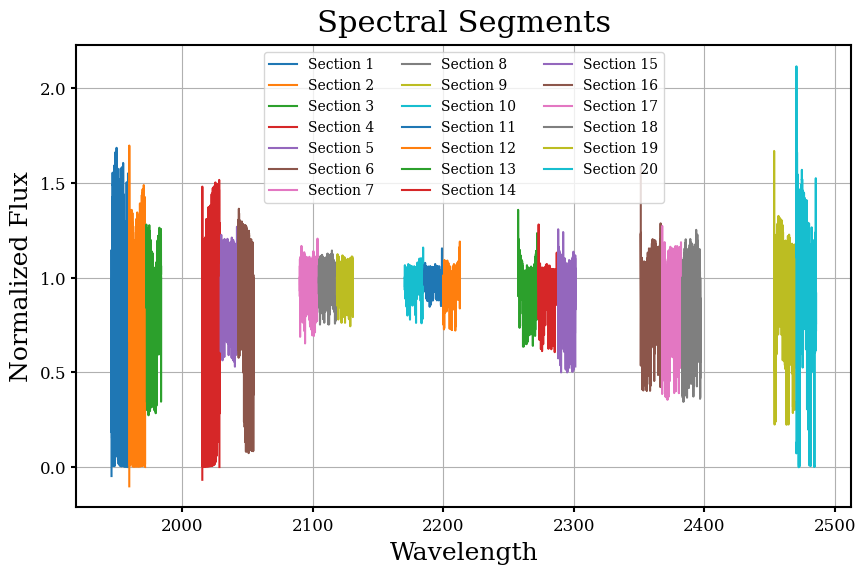

In [4]:
# quick plot to check that our gaps are nice
wave_row = wave[0]
flux_row = normalized_flux_array[0]
gaps = gaps_arr[0]

# Include start (0) and end (last index) for full coverage
segment_edges = [0] + list(gaps) + [len(wave_row)]

plt.figure(figsize=(10, 6))

for i in range(len(segment_edges) - 1):
    start = segment_edges[i]
    end = segment_edges[i + 1]
    plt.plot(wave_row[start:end], flux_row[start:end], label=f"Section {i+1}")

plt.legend(ncol=3)
plt.xlabel("Wavelength")
plt.ylabel("Normalized Flux")
plt.title("Spectral Segments")
plt.grid(True)
plt.show()

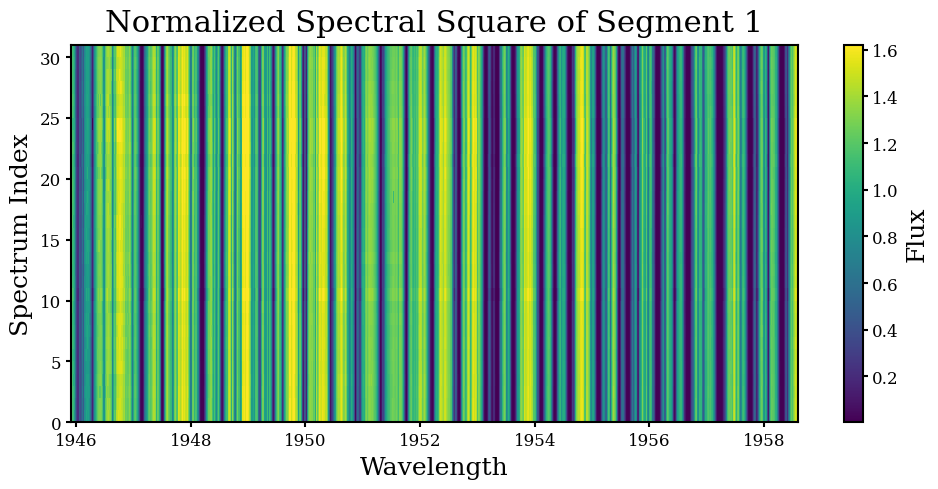

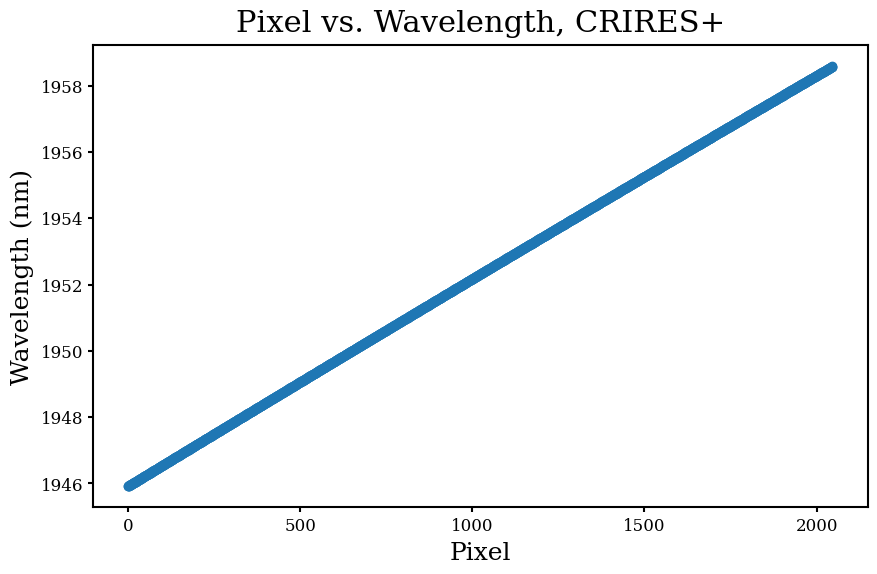

In [5]:
# for this example, we will only run the pipeline on one detector
wave_1 = wave[0, 0:gaps[0]]
flux_1 = normalized_flux_array[:, 0:gaps[0]]

from pipeline.pca_diagnostics import plot_spectral_square
plot_spectral_square(flux_1, wave_1, title="Normalized Spectral Square of Segment 1")

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(wave_1)), wave_1)
plt.title("Pixel vs. Wavelength, CRIRES+")
plt.ylabel("Wavelength (nm)")
plt.xlabel("Pixel")
plt.show()



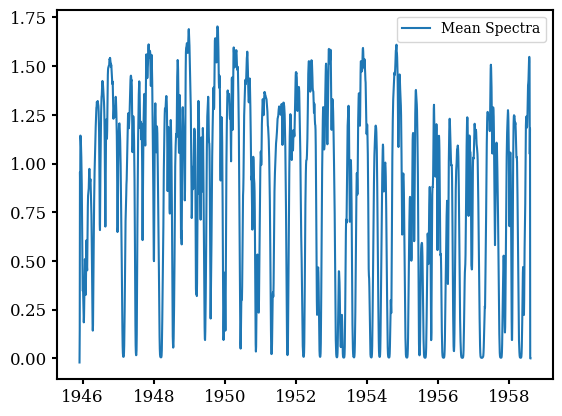

In [6]:
# 2 Take the mean spectrum of each detector

mean_flux = np.nanmean(flux_1, axis=0)
plt.plot(wave_1, mean_flux, label="Mean Spectra")
plt.legend()
plt.show()

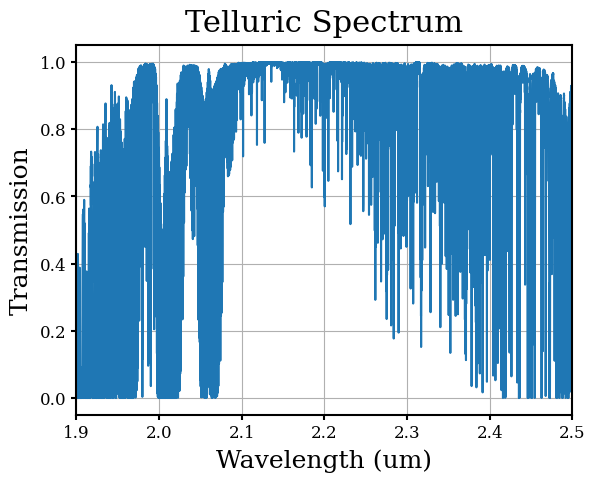

In [7]:
# 3.1.1 Load telluric spectrum
from astropy.io import fits

telluric_spectrum = "/home/ktpha/chile-tellurics/eso_skycalc_tellurics/LBL_A15_s0_R0060000_T.fits"

with fits.open(telluric_spectrum) as hdul:
    telluric_wave = hdul[1].data['lam'] 
    telluric_flux = hdul[1].data['trans'] 

plt.plot(telluric_wave, telluric_flux)
plt.title("Telluric Spectrum")
plt.xlabel("Wavelength (um)")
plt.ylabel("Transmission")
plt.xlim(1.9, 2.5) # approx. crires+ range
plt.grid()
plt.show()

(1.945, 1.96)

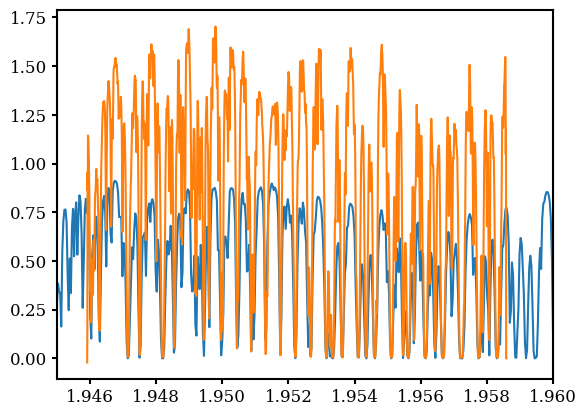

In [60]:
plt.plot(telluric_wave, telluric_flux)
plt.plot(wave_um, mean_flux)
plt.xlim(1.945, 1.96)

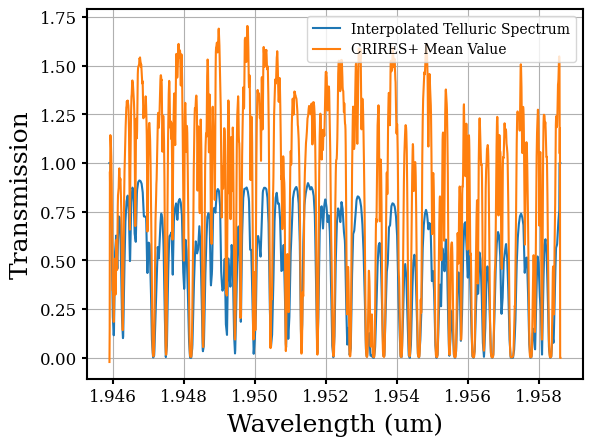

In [ ]:
# 3.1.2 interpolate tellurics to ~data from the given wavelength range
from scipy.interpolate import interp1d

# Convert wave_1 to microns to match telluric_wave units
wave_um = wave_1 * 0.001

# Get min/max wavelength from the data wavelength array 
data_wave_min = np.min(wave_um) 
data_wave_max = np.max(wave_um) 

# Mask telluric arrays to this range
mask = (telluric_wave >= data_wave_min) & (telluric_wave <= data_wave_max)
telluric_wave_masked = telluric_wave[mask]
telluric_flux_masked = telluric_flux[mask]

# Create interpolator
interp_func = interp1d(telluric_wave_masked, telluric_flux_masked, bounds_error=False, fill_value=1.0)

# Interpolate to data wavelength grid
telluric_flux_resampled = interp_func(wave_um)

plt.plot(wave_um, telluric_flux_resampled, label="Interpolated Telluric Spectrum")
plt.plot(wave_um, mean_flux, label="CRIRES+ Mean Value")
plt.xlabel("Wavelength (um)")
plt.ylabel("Transmission")
plt.legend()
plt.grid()
plt.show()

In [73]:
from scipy.signal import find_peaks
import numpy as np

def get_peak_absorptions(wave_arr, flux_arr, N=65, without_extremities=None):
    """Function to get top N absroption features"""

    if without_extremities is not None:
        flux = flux_arr[without_extremities:-without_extremities]
    else: 
        flux = flux_arr

    all_peaks, _ = find_peaks(-flux)
    flux_peaks = flux[all_peaks]
    idx = np.argsort(flux_peaks)[:N]
    data_peaks_unsorted = all_peaks[idx]
    
    wavelengths = wave_arr[data_peaks_unsorted]
    sorted_idx = np.argsort(wavelengths)
    sorted_peaks = data_peaks_unsorted[sorted_idx]

    return sorted_peaks

data_peaks = get_peak_absorptions(wave_um, mean_flux, without_extremities=10)
tel_peaks = get_peak_absorptions(wave_um, telluric_flux_resampled, without_extremities=10)

# N = 50

# # 3.2 Isolate top 50 data peaks 
# without_extremities = mean_flux[5:-5]
# all_peaks, _ = find_peaks(-without_extremities)  # Find minima
# data_peaks = without_extremities[all_peaks]
# data_idx = np.argsort(data_peaks)[:N]
# data_peaks_unsorted = all_peaks[data_idx]

# print(data_peaks.shape)

# # 3.3 Isolate top-N deepest telluric peaks
# all_tel_peaks, _ = find_peaks(-telluric_flux_resampled)
# peak_tel_fluxes = telluric_flux_resampled[all_tel_peaks]
# print(all_tel_peaks.shape)

# #N = len(data_peaks)
# top_idx = np.argsort(peak_tel_fluxes)[:N]              # deepest N
# tel_peaks_unsorted = all_tel_peaks[top_idx]

# # Sort by wavelength (assuming telluric_wavelength is defined)
# tel_wavelengths = telluric_wave_resampled[tel_peaks_unsorted]
# sorted_idx = np.argsort(tel_wavelengths)

# tel_peaks = tel_peaks_unsorted[sorted_idx]         # final sorted indices


In [74]:
# 4 fit peaks to gaussians

from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + offset

def fit_gaussian_to_peaks(x, y, peaks, window=5):
    centroids = []
    for idx in peaks:
        left = max(0, idx - window)
        right = min(len(x), idx + window + 1)
        x_fit = x[left:right]
        y_fit = y[left:right]
        # Initial guesses
        amp_guess = np.min(y_fit) - np.median(y_fit)
        mu_guess = x[idx]
        sigma_guess = (x_fit[-1] - x_fit[0]) / 6 if len(x_fit) > 1 else 1
        offset_guess = np.median(y_fit)
        try:
            popt, _ = curve_fit(
                gaussian, x_fit, y_fit,
                p0=[amp_guess, mu_guess, sigma_guess, offset_guess]
            )
            centroids.append(popt[1])
        except Exception:
            centroids.append(mu_guess)
    return np.array(centroids)

# 4.1 fit data peaks to gaussians
data_centroids = fit_gaussian_to_peaks(wave_um, mean_flux, data_peaks)
tel_centroids = fit_gaussian_to_peaks(wave_um, telluric_flux_resampled, tel_peaks)


/tmp/ipykernel_1483/3886622853.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


In [75]:
print(data_centroids.shape, tel_centroids.shape)

(65,) (65,)


In [76]:
# 5, 6

from scipy.interpolate import interp1d
from numpy.polynomial import Polynomial
import numpy as np

def fit_single_segment_to_wavelengths(segment_centroids, tel_centroids_segment, telluric_wavelength, deg=3):
    """
    Fit a polynomial mapping data pixel positions to wavelengths for a single segment.

    Parameters:
        data_pix (np.ndarray): Pixel positions from the science data (segment centroids).
        tel_wave (np.ndarray): Wavelengths of telluric features in this segment.
        telluric_wavelength (np.ndarray): Full telluric wavelength array.
        deg (int): Degree of the polynomial fit.

    Returns:
        Polynomial: Best-fit Polynomial mapping data_pix → wavelength.
    """
    pixel_grid = np.arange(len(telluric_wavelength))

    # Interpolators
    interp_wave = interp1d(pixel_grid, telluric_wavelength, kind='linear', bounds_error=False, fill_value=np.nan)
    interp_idx = interp1d(telluric_wavelength, pixel_grid, kind='linear', bounds_error=False, fill_value=np.nan)

    # Convert telluric wavelengths to pixel positions, then map to wavelengths again
    tel_pix = interp_idx(tel_centroids_segment)
    wave_vals = interp_wave(tel_pix)

    # Mask invalid entries
    mask = ~np.isnan(segment_centroids) & ~np.isnan(wave_vals)
    if np.count_nonzero(mask) < deg + 1:
        raise ValueError("Not enough valid points for fitting.")

    # Fit and return the polynomial
    poly = Polynomial.fit(segment_centroids[mask], wave_vals[mask], deg=deg).convert()
    return poly


poly = fit_single_segment_to_wavelengths(
    segment_centroids=data_centroids,               # 1D array of pixel centroids from science data
    tel_centroids_segment=tel_centroids,           # 1D array of telluric centroid wavelengths
    telluric_wavelength=wave_um,
    deg=5
)


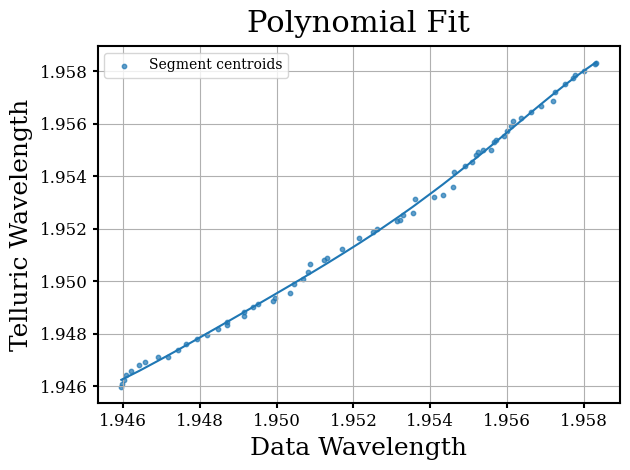

In [77]:
x = data_centroids
y_fit = poly(data_centroids)
y_true = tel_centroids

plt.plot(x, y_fit)
plt.scatter(x, y_true, s=10, alpha=0.7, label=f"Segment centroids")

plt.xlabel("Data Wavelength")
plt.ylabel("Telluric Wavelength")
plt.title("Polynomial Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1483/2275340424.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


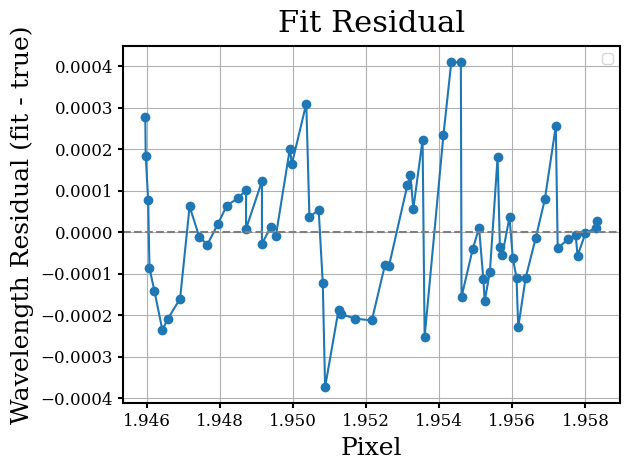

In [78]:
#6

# Evaluate fit
fitted_wavelengths = poly(data_centroids)
residuals = fitted_wavelengths - tel_centroids

# Optional: plot residuals
plt.plot(data_centroids, residuals, 'o-')

plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Pixel")
plt.ylabel("Wavelength Residual (fit - true)")
plt.title("Fit Residual")
plt.legend()
plt.grid(True)
#plt.ylim(-0.006, 0.006)
plt.tight_layout()
plt.show()


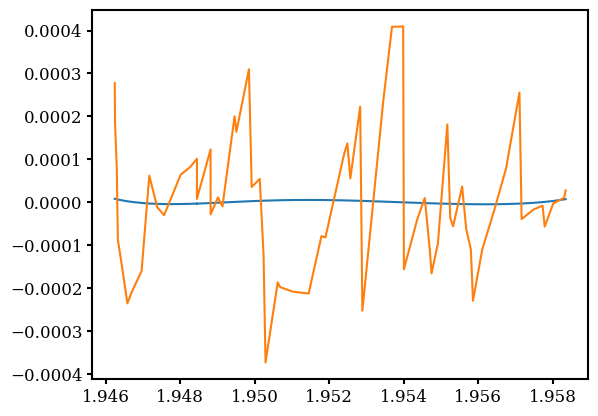

In [79]:
def check_uncorrelated_residuals(poly, data_centroids, tel_centroids):
    fitted_wavelengths = poly(data_centroids)
    residuals = fitted_wavelengths - tel_centroids

    poly = Polynomial.fit(fitted_wavelengths, residuals, deg=4).convert()

    plt.plot(fitted_wavelengths, poly(data_centroids))
    plt.plot(fitted_wavelengths, residuals)

check_uncorrelated_residuals(poly, data_centroids, tel_centroids)
    


In [80]:
# 7
from astropy.constants import c

def precision(residuals, wave_arr):
    """wave_arr in nm"""
    std = np.std(residuals)
    central_wave = np.median(wave_arr)
    return std * c / (central_wave * 1e3)

deltaV = precision(residuals, poly(data_centroids))
print(deltaV)


24.255773614465813 m / s


In [81]:
# interpolate data wave : telluric wave relation

interp_func = interp1d(data_centroids, poly(data_centroids), kind='cubic', bounds_error=False, fill_value='extrapolate')
y_interp = interp_func(wave_um)

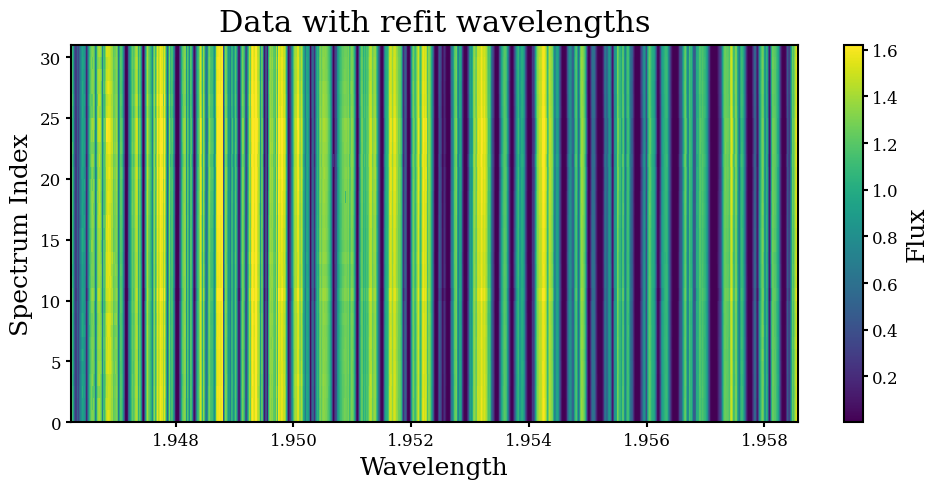

In [82]:
# 8


plot_spectral_square(flux_1, y_interp, title="Data with refit wavelengths")


(1.945, 1.96)

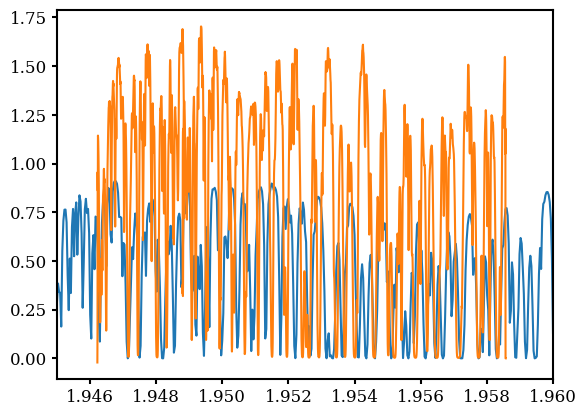

In [83]:
plt.plot(telluric_wave, telluric_flux)
plt.plot(y_interp, mean_flux)
plt.xlim(1.945, 1.96)


In [17]:
from calibration import calibrate_cr2res

dat_wav = calibrate_cr2res(wave[0] * 0.001, flux, telluric_wave, telluric_flux, gap_size_px=5, poly_order=5)

flux, wavelength array shape (31, 14336) (14336,)
masked flux, pixel array shape (31, 14309) (14309,)


/home/ktpha/chile-tellurics/code/calibration.py:41: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


Segment 0: 72 centroids
Segment 1: 70 centroids
Segment 2: 29 centroids
Segment 3: 0 centroids
Segment 4: 34 centroids
Segment 5: 92 centroids
Segment 6: 78 centroids
1.94696943 - (2.34870289e-06)·x + (4.4351774e-08)·x² -
(6.17911327e-11)·x³ + (3.4083712e-14)·x⁴ - (6.43590339e-18)·x⁵
12.59602933 - 0.01844171·x + (1.25234966e-05)·x² - (4.16664735e-09)·x³ +
(6.81326328e-13)·x⁴ - (4.38988053e-17)·x⁵
10.31341397 - 0.00858279·x + (3.51864585e-06)·x² - (7.15852156e-10)·x³ +
(7.23060352e-14)·x⁴ - (2.90128156e-18)·x⁵
544.73552327 - 0.28753642·x + (6.08219443e-05)·x² - (6.42099329e-09)·x³ +
(3.38318886e-13)·x⁴ - (7.11740761e-18)·x⁵
-58614.08401054 + 26.15529557·x - 0.00466225·x² + (4.14983159e-07)·x³ -
(1.84442592e-11)·x⁴ + (3.27476624e-16)·x⁵
-32798.56406326 + 12.32211604·x - 0.00185015·x² + (1.3879078e-07)·x³ -
(5.2018102e-12)·x⁴ + (7.79263306e-17)·x⁵


/home/ktpha/chile-tellurics/code/calibration.py:250: RuntimeWarning: invalid value encountered in cast
  pixels = pixels.astype(int)


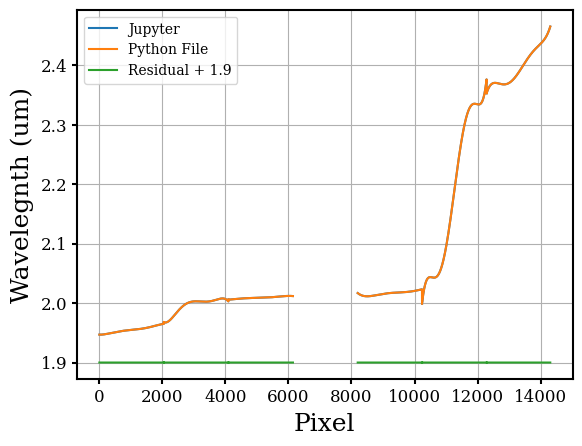

In [18]:
plt.plot(data_wavelengths, label="Jupyter")
plt.plot(dat_wav, label="Python File")
plt.plot(data_wavelengths - dat_wav + 1.9, label="Residual + 1.9")
plt.legend()
plt.grid()
plt.xlabel("Pixel")
plt.ylabel("Wavelegnth (um)")
plt.show()

In [19]:
path = "/home/ktpha/chile-tellurics/pre/full_spectra/"
np.savez(path + "wave_calibrated.npz", wave=dat_wav, flux=valid_flux)